# Machine Learning Engineer Nanodegree - Capstone Project
## PART 2: Benchmark Models

**Author:** Giacomo Sarchioni

## Module imports

In [3]:
# Module imports
from naive_classifier import NaiveModel
from roc_chart import ROCChart
import pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.externals import joblib
random_seed = 42
import pandas as pd

Load sentiment reviews dataframe.

In [4]:
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)

Load train, validation and test indexes

In [5]:
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

## Naive Benchmark Model
The Naive Benchmark model always predicts the most frequent class in the training set.

In [73]:
# Extract parser_zero_reviews and scores
parser_zero_reviews = sentiment_reviews.loc[:,'parser_zero'].values
scores = sentiment_reviews.adj_score.values

# Extract non test parser zero reviews and scores
non_test_parser_zero_reviews = parser_zero_reviews[indexes['non_test']]
non_test_scores = scores[indexes['non_test']]

# Extract train parser zero reviews and scores
train_parser_zero_reviews = non_test_parser_two_reviews[indexes['train']]
train_scores = non_test_scores[indexes['train']]

# Extract val parser zero reviews and scores
val_parser_zero_reviews = non_test_parser_two_reviews[indexes['val']]
val_scores = non_test_scores[indexes['val']]

# Extract test parser zero reviews and scores
test_parser_zero_reviews = parser_zero_reviews[indexes['test']]
test_scores = scores[indexes['test']]

In [82]:
# Initialise Naive benchmark model
naive_model = NaiveModel()

# Fit model on non_test_scaores
naive_model.fit(val_scores)

# Predict on test_parser_zero_reviews
naive_model_val_predictions = naive_model.predict(val_parser_zero_reviews)

AUC score for Naive Model is 0.5000


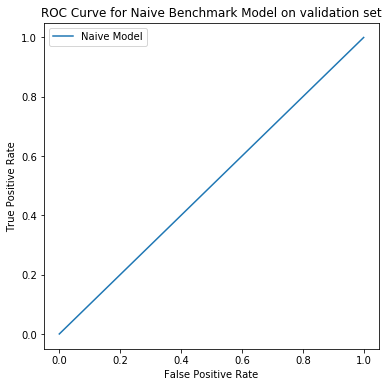

In [83]:
# Create ROC Chart for Naive Model
naive_chart = ROCChart(val_scores, [naive_model_val_predictions], ["Naive Model"], "ROC Curve for Naive Benchmark Model on validation set")
naive_chart.plot()

In [84]:
# Naive model predictions on test data
naive_model_test_predictions = naive_model.predict(test_parser_zero_reviews)

In [85]:
# Save naive model
joblib.dump(naive_model, 'bmk_models/bmk_naive.pkl')

['bmk_models/bmk_naive.pkl']

## Bag-of-words model

In [15]:
# Extract parser_one_reviews
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

# Extract non test parser two reviews and scores
non_test_parser_one_reviews = parser_one_reviews[indexes['non_test']]
test_parser_one_reviews = parser_one_reviews[indexes['test']]

In [69]:
# Extract train and validation parser-one reviews
train_parser_one_reviews = non_test_parser_one_reviews[indexes['train']]
val_parser_one_reviews = non_test_parser_one_reviews[indexes['val']]

In `scikit-learn`'s `TfidfVectorizer` there a series of parameters which are worth investigating, and direclty linked to the size of the word vocabulary. They are:

- `max_df`, i.e. "when building the vocabulary [the algorithm] ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)". By default, this value is set to 1.0 (float). This means that if a word is present in **all documents** (in our case in all reviews), then it will be ignored in the word vocabulary. This makes sense, since if a word is present in all reviews (positive and negative), then it probably doesn't give too much information about the sentiment.
- `min_df`, i.e. "when building the vocabulary [the algorithm] ignore terms that have a document frequency strictly lower than the given threshold". By default, this value is set to 1 (int). This means if a word only appears in one document (i.e. one review), then it will be ignored. This makes sense since while we want to give more importance to rare words, we don't want our algorithm to learn/memorise very very specific cases;
- `max_features`, i.e. "if not None, [the algorithm] build a vocabulary that only consider the top max_features ordered by term frequency across the corpus". If `None`, the vocabulary is made of all the unique words available in the corpus. This means that every sentence is translated into a `1 x n` array, where `n` is the number of words in the vocabulary.  
  
While I believe that the default values for `max_df` and `min_df` are reasonable, I would be more cautious when it comes to setting the value of `max_features`. 

#### `ngram_range` comparison

In [17]:
# Create tf-idf vectoriser with ngram_range equal to (1,1)
basic_tfidf = TfidfVectorizer()

# Create tf-idf vectoriser with ngram_range equal to (1,2)
basic_tfidf_range = TfidfVectorizer(ngram_range=(1,2))

In [20]:
# Fit the vectorisers to train data
basic_tfidf.fit(train_parser_one_reviews)
basic_tfidf_range.fit(train_parser_one_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
# Print vocabulary size
print('Vocabulary size for tf-idf with ngram_range equal to (1,1) is {}.'.format(len(basic_tfidf.vocabulary_)))
print('Vocabulary size for tf-idf with ngram_range equal to (1,2) is {}.'.format(len(basic_tfidf_range.vocabulary_)))

Vocabulary size for tf-idf with ngram_range equal to (1,1) is 106657.
Vocabulary size for tf-idf with ngram_range equal to (1,2) is 2535871.


In [29]:
# Transform training and validation data
no_range_train = basic_tfidf.transform(train_parser_one_reviews)
no_range_val = basic_tfidf.transform(val_parser_one_reviews)
range_train = basic_tfidf_range.transform(train_parser_one_reviews)
range_val = basic_tfidf_range.transform(val_parser_one_reviews)

In [30]:
# Fit logistic regression
lr = LogisticRegression(random_state=random_seed, solver='sag', n_jobs=-1)
lr_range = LogisticRegression(random_state=random_seed, solver='sag', n_jobs=-1)

In [31]:
# Fit the logistic regression models
lr.fit(no_range_train, train_scores)
lr_range.fit(range_train, train_scores)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# Predict sentiment on validation data
pred_no_range = lr.predict(no_range_val)
pred_range = lr_range.predict(range_val)

AUC score for ngram 1 is 0.8324
AUC score for ngram 2 is 0.8468


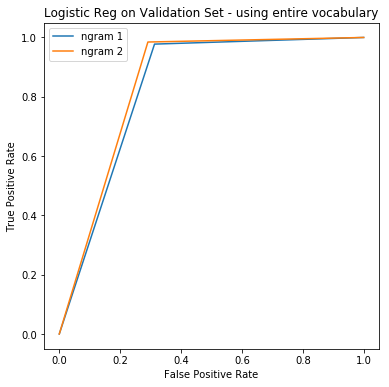

In [52]:
# Plot chart
ngram_comparison_chart = ROCChart(val_scores,
                                  [pred_no_range, pred_range],
                                  ['ngram 1', 'ngram 2'], 'Logistic Reg on Validation Set - using entire vocabulary')
ngram_comparison_chart.plot()

### tf-idf vectoriser

In [77]:
# Define bmk_vectoriser
bmk_vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=30000)

In [78]:
# Transform data using the vectoriser
bmk_train_data = bmk_vectoriser.fit_transform(train_parser_one_reviews)
bmk_val_data = bmk_vectoriser.transform(val_parser_one_reviews)
bmk_test_data = bmk_vectoriser.transform(test_parser_one_reviews)

In [79]:
# Fit benchmark logistic regression
bmk_log_reg = LogisticRegression(random_state=random_seed, solver='sag', n_jobs=-1)
bmk_log_reg.fit(bmk_train_data, train_scores)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
# Predict sentiment on validation data
bmk_val_pred = bmk_log_reg.predict(bmk_val_data)

AUC score for 30000 word vocabulary is 0.8609


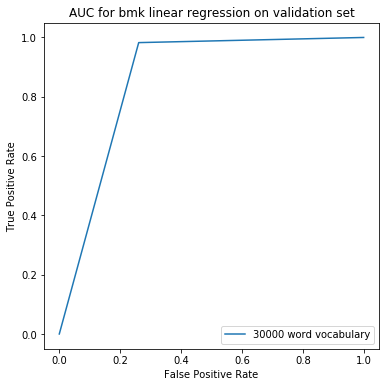

In [81]:
bmk_lr_chart = ROCChart(val_scores, [bmk_val_pred], ['30000 word vocabulary'], 'AUC for bmk linear regression on validation set')
bmk_lr_chart.plot()

In [86]:
# Print two-words item in vectorisation vocabulary
counter = 0
for i, _ in bmk_vectoriser.vocabulary_.items():
    if counter < 50:
        if len(i.split()) > 1:
            print(i)
            counter+=1

other reviewers
here that
that gave
gave this
this bar
must have
have been
off by
are the
the worst
worst tasting
protein bars
bars ve
ve ever
ever tasted
tasted in
in my
my life
at least
other brands
try to
to make
make their
not even
going to
to try
try the
the bar
has any
white chocolate
chocolate taste
taste to
to it
it the
bar is
is bitter
bitter and
and dry
dry it
it took
took me
minutes to
to finish
because it
it tasted
tasted so
so bad
will never
never buy
buy another


In [87]:
# Create pipeline
from sklearn.pipeline import Pipeline
bmk_model = Pipeline([('tf-idf', bmk_vectoriser), ('lr', bmk_log_reg)])

In [88]:
# Save pipeline object
joblib.dump(bmk_model, 'bmk_models/bmk_log_reg.pkl')

['bmk_models/bmk_log_reg.pkl']